In [1]:
import pennylane as qml
import tensorflow as tf
from pennylane import numpy as np
import matplotlib.pyplot as plt

2023-05-28 09:30:48.661612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
wires = range(5)
n_layers = 1
dev = qml.device('default.mixed', wires=len(wires))

In [3]:
dataset = np.load('/Users/neda/Dropbox/My Mac (Marzieh’s MacBook)/Downloads/dataset.npy', allow_pickle=True)

dis_dataset = dataset[1]
print(dataset.shape)
print(dataset[1].shape)
print(dataset[1][0].shape)
print(dataset[1][1].shape)
print(len(dataset[1][0]))
print(dataset[1][0][0].shape)
print(dataset[1][0][0][0].shape)
print(dataset[1][0][0][0])
print(type(dataset))

(6, 2)
(2,)
(2418, 2)
(605, 2)


/Applications/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


2418
(2,)
(15,)
[-0.32630116 -0.52672888  0.22980389  0.45905497  1.         -0.13749332
 -0.25141721 -0.33721648  0.16609539  0.35541316 -0.23296043 -0.34555093
  0.49395614  0.52312879 -0.08387162]
<class 'pennylane.numpy.tensor.tensor'>


In [4]:
import torch
transformed_dataset = [[[[tensor[:5] for tensor in inner] for inner in middle] for middle in outer] for outer in dataset]
print(type(transformed_dataset))
array_dataset = np.array(transformed_dataset)
print(type(array_dataset))
# Check the shape of the first tensor in the transformed dataset
#print(transformed_dataset[0][0][0][0].shape)

/Applications/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


<class 'list'>
<class 'pennylane.numpy.tensor.tensor'>


In [ ]:
#print(transformed_dataset[1][0][:50]) 


In [5]:
#blocks = 3
p = 0.01
@qml.qnode(dev, interface="tf", diff_method="best")
def gen_circuit(b_seq, gen_weights):
    # Embedding past time series onto circuit as conditional labels
    qml.templates.AngleEmbedding(b_seq, wires, rotation='X')
    # Adjusting parameters of generator ansatz
    qml.templates.StronglyEntanglingLayers(gen_weights, wires=wires)
    qml.DepolarizingChannel(p, wires=0)
    qml.DepolarizingChannel(p, wires=1)
    # Returning normalized percentage price predictions for next 4 days in dataset 
    return [qml.expval(qml.PauliZ(i)) for i in range(len(dis_dataset[0][1][1]))]

In [6]:
len(dis_dataset[0][1][1])

4

In [7]:
shape = qml.StronglyEntanglingLayers.shape(n_layers, n_wires=len(wires))
print(shape)

(1, 5, 3)


In [8]:
init_gen_weights = tf.Variable(np.random.uniform(-np.pi, np.pi, shape))

2023-05-28 09:32:35.011077: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
init_gen_weights[0]

<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[-2.64888631, -0.33491316,  1.1768369 ],
       [ 2.916831  ,  1.09470403,  1.22116918],
       [-2.02110229,  1.9650393 ,  1.06619134],
       [-0.98159868, -2.01505295, -0.92087857],
       [-1.23885574,  1.62421531,  1.71267918]])>

In [10]:
dis_dataset[0][1][0]
#feature = tf.Variable(np.random.uniform(-np.pi, np.pi, len(wires)))
feature = array_dataset[1][0][1][0]
print(feature)
print(dis_dataset[0][1][0])

[ 0.06052519  0.30713055 -0.03775722  1.          0.07177394]
[ 0.06052519  0.30713055 -0.03775722  1.          0.07177394  0.31660608
  0.16565594 -0.05471963  0.13472587 -0.58454127  0.32745685  0.04524029
 -0.16046781 -0.29319074  0.01568178]


In [11]:
# Testing generator circuit QNode
gen_circuit(feature, init_gen_weights)

/Applications/anaconda3/lib/python3.9/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'tensorflow', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


[<tf.Tensor: shape=(), dtype=float64, numpy=0.0019272109444113394>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.34714238003219333>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-0.1460861119101759>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.12620290953364838>]

In [12]:
def make_discrim():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1, input_shape=[1, 9]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(tf.keras.layers.Dropout(.3))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    return model

In [13]:
discriminator = make_discrim()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 16)             160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 16)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 16)             272       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1, 16)             0         
                                                                 
 dropout (Dropout)           (None, 1, 16)             0         
                                                                 
 dense (Dense)               (None, 1, 128)            2176      
                                                                 
 dense_1 (Dense)             (None, 1, 1)              1

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def generator_loss(fake_output):
    """Calculating loss"""
    return cross_entropy(np.ones_like(fake_output), fake_output)

In [15]:
def discriminator_loss(fake_output, real_output):    
    """Compute discriminator loss.""" 
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [16]:
def accuracy(real_data, fake_data):
    m = tf.keras.metrics.MeanAbsoluteError()
    m.update_state(real_data, fake_data)
    acc = 1 - m.result().numpy()
    return acc

In [28]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [29]:
def train_step(equity_data, gen_weights):
    """Run train step on provided image batch."""
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape: 
        generated_prices = tf.concat([equity_data[0], gen_circuit(equity_data[0], gen_weights)], 0)
        generated_prices = tf.reshape(generated_prices, (1,1,(len(equity_data[0]) + len(equity_data[1]))))

        real_prices = tf.concat([equity_data[0], equity_data[1]], 0)
        real_prices = tf.reshape(real_prices, (1,1,(len(equity_data[0]) + len(equity_data[1]))))
        
        """Getting outputs from discrim"""
        real_output = discriminator(real_prices)
        fake_output = discriminator(generated_prices)
        
        """Calculating loss"""
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(fake_output, real_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, gen_weights)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip([gradients_of_generator], [gen_weights]))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    """Accuracy"""
    acc = accuracy(equity_data[1], gen_circuit(equity_data[0], gen_weights))
    
    return gen_loss, disc_loss, gen_weights, acc

In [30]:
gloss = []
dloss = []
acc_results = []
epoch_acc_results = []


In [31]:
EPOCHS = 10
batch_size = 1

def train(dataset, epochs, start_epoch=1, new_gen_w=None):    
    for epoch in range(start_epoch, start_epoch + epochs):
        if epoch == 1:
            new_gen_w = tf.Variable(np.ones_like(init_gen_weights.numpy()), dtype="float64")
            new_gen_w.assign(init_gen_weights)
        
        for i, sample in enumerate(dataset[0:batch_size]):
            sample_b = sample[0]
            sample_f = sample[1]
            gl, dl, w, acc = train_step(dataset[i], new_gen_w)
            
            new_gen_w.assign(w)
            acc_results.append(acc)
            gloss.append(gl)
            dloss.append(dl)
        
            if epoch % 10 == 0:
                print(f"Step {i} in {epoch} epoch: Gen loss: {gl} \n         Disc loss: {dl} \n             Accuracy: {acc}")
        
        epoch_acc = 0
        for i, sample in enumerate(dataset[0:batch_size]):
            epoch_acc += accuracy(sample[1], gen_circuit(sample[0], new_gen_w))
        epoch_acc = epoch_acc / len(dataset[0:batch_size])
        epoch_acc_results.append(epoch_acc)

    return new_gen_w
    

In [32]:
#print(dis_dataset[0].shape)
dis_transformed_dataset = array_dataset[1]
print(dis_transformed_dataset[0][:1])
print('------------------------------------')
print(dis_dataset[0][:1])

[[tensor([-0.32630116, -0.52672888,  0.22980389,  0.45905497,  1.        ], requires_grad=True)
  tensor([-0.08387162, -0.629808  ,  0.04090421, -0.04757502], requires_grad=True)]]
------------------------------------
[[tensor([-0.32630116, -0.52672888,  0.22980389,  0.45905497,  1.        ,
          -0.13749332, -0.25141721, -0.33721648,  0.16609539,  0.35541316,
          -0.23296043, -0.34555093,  0.49395614,  0.52312879, -0.08387162], requires_grad=True)
  tensor([-0.08387162, -0.629808  ,  0.04090421, -0.04757502], requires_grad=True)]]


In [33]:
new_gen_w = train(dis_transformed_dataset[0], EPOCHS, start_epoch=1) 

Step 0 in 10 epoch: Gen loss: 0.6998463869094849 
         Disc loss: 1.3665332794189453 
             Accuracy: 0.6351791322231293


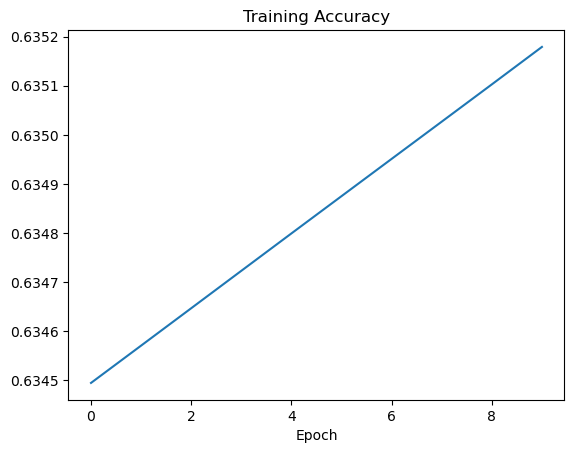

In [34]:
plt.plot(range(len(epoch_acc_results)), epoch_acc_results)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.show()

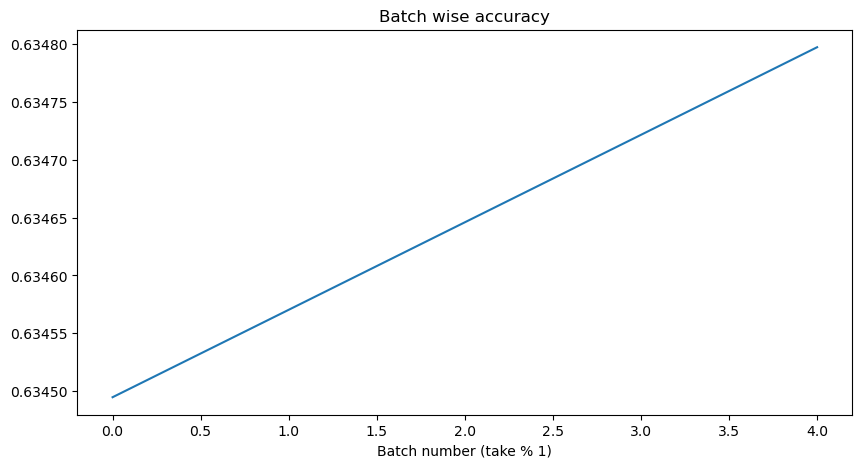

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(acc_results)), acc_results)
plt.title("Batch wise accuracy")
plt.xlabel(f"Batch number (take % {batch_size})")
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(gloss)), gloss, label="Generator loss")
plt.plot(range(len(dloss)), dloss, label="Discriminator loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

![](./images/qgan_ex_1.png)
![](./images/qgan_ex_2.png)
![](./images/qgan_ex_3.png)
![](./images/qgan_ex_4.png)
![](./images/qgan_ex_5.png)

<hr>